In [2]:
import numpy as np
import csv
from collections import defaultdict, Counter
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.optimize import nnls

### Dataset preparation

In [3]:
# reading from raw input files to get movie name, id and genres
movies = defaultdict(dict)
all_genres = set()
movies_genre_df_list = []
with open('./Dataset_MovieSummaries/movie.metadata.tsv', encoding='utf-8') as f:
    movie_metadata = csv.reader(f, delimiter='\t')

    # Extracting genres from the metadata
    for line in movie_metadata:
        values = json.loads(line[8]).values()
        genres = list(values)
        all_genres.update(values)
        movies_genre_df_list.append([int(line[0]), line[2], tuple(genres)])


In [4]:
movies_genre = pd.DataFrame(movies_genre_df_list, columns = ['movie_id', 'movie_name', 'genres'])
movies_genre

,movie_id,movie_name,genres
0,975900,Ghosts of Mars,"(Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,"(Mystery, Biographical film, Drama, Crime Drama)"
2,28463795,Brun bitter,"(Crime Fiction, Drama)"
3,9363483,White Of The Eye,"(Thriller, Erotic thriller, Psychological thri..."
4,261236,A Woman in Flames,"(Drama,)"
...,...,...,...
81736,35228177,Mermaids: The Body Found,"(Drama,)"
81737,34980460,Knuckle,"(Biographical film, Drama, Documentary)"
81738,9971909,Another Nice Mess,"(Satire, Comedy)"
81739,913762,The Super Dimension Fortress Macross II: Lover...,"(Science Fiction, Japanese Movies, Adventure, ..."


In [5]:
movie_descriptions = []
with open('./Dataset_MovieSummaries/plot_summaries.txt', encoding='utf-8') as f2:
    movie_description = csv.reader(f2, delimiter='\t')
    
    for line in movie_description:
        
        description = line[1]
        id_ = int(line[0])
        movie_descriptions.append([id_, description])
summary_df = pd.DataFrame(movie_descriptions, columns = ['movie_id', 'summary'])

In [6]:
summary_df

,movie_id,summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...
...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho..."
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look..."
42300,35102018,American Luthier focuses on Randy Parsons’ tra...
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se..."


In [7]:
movies_genre = pd.merge(movies_genre, summary_df, on='movie_id', how='inner')
movies_genre

,movie_id,movie_name,genres,summary
0,975900,Ghosts of Mars,"(Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th..."
1,9363483,White Of The Eye,"(Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...
2,261236,A Woman in Flames,"(Drama,)","Eva, an upper class housewife, becomes frustra..."
3,18998739,The Sorcerer's Apprentice,"(Family Film, Fantasy, Adventure, World cinema)","Every hundred years, the evil Morgana returns..."
4,6631279,Little city,"(Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a..."
...,...,...,...,...
42199,23851782,The Ghost Train,"(Crime Fiction, Thriller, Comedy, Supernatural)",{{plot}} The film opens with a Great Western e...
42200,35228177,Mermaids: The Body Found,"(Drama,)",Two former National Oceanic Atmospheric Admini...
42201,34980460,Knuckle,"(Biographical film, Drama, Documentary)",{{No plot}} This film follows 12 years in the ...
42202,913762,The Super Dimension Fortress Macross II: Lover...,"(Science Fiction, Japanese Movies, Adventure, ...","The story takes place in the year 2092,The Sup..."


In [8]:
# remove genres that occur less than 3000 times
genre_counts = Counter(list(item for sublist in movies_genre['genres'] for item in sublist))
genres_to_remove = [genre for genre, count in genre_counts.items() if count < 3000]
genres_to_remove.extend(['Comedy film','Black-and-white', 'Indie','World cinema'])
def remove_sparse_genres(genre_list):
    return tuple([genre for genre in genre_list if genre not in  genres_to_remove])
movies_genre['genres'] = movies_genre['genres'].apply(remove_sparse_genres)
genres_labels = list(set(item for sublist in movies_genre['genres'] for item in sublist))

In [9]:
mlb = MultiLabelBinarizer()
genres_binary = mlb.fit_transform(movies_genre['genres'])
genres_binary_df = pd.DataFrame(genres_binary, columns=mlb.classes_)
movies_genres_df = pd.concat([movies_genre[['movie_id', 'movie_name', 'summary']], genres_binary_df], axis=1)

In [10]:
movies_genres_df

,movie_id,movie_name,summary,Action,Action/Adventure,Adventure,Comedy,Crime Fiction,Drama,Family Film,Horror,Romance Film,Short Film,Thriller
0,975900,Ghosts of Mars,"Set in the second half of the 22nd century, th...",1,0,1,0,0,0,0,1,0,0,1
1,9363483,White Of The Eye,A series of murders of rich young women throug...,0,0,0,0,0,0,0,0,0,0,1
2,261236,A Woman in Flames,"Eva, an upper class housewife, becomes frustra...",0,0,0,0,0,1,0,0,0,0,0
3,18998739,The Sorcerer's Apprentice,"Every hundred years, the evil Morgana returns...",0,0,1,0,0,0,1,0,0,0,0
4,6631279,Little city,"Adam, a San Francisco-based artist who works a...",0,0,0,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42199,23851782,The Ghost Train,{{plot}} The film opens with a Great Western e...,0,0,0,1,1,0,0,0,0,0,1
42200,35228177,Mermaids: The Body Found,Two former National Oceanic Atmospheric Admini...,0,0,0,0,0,1,0,0,0,0,0
42201,34980460,Knuckle,{{No plot}} This film follows 12 years in the ...,0,0,0,0,0,1,0,0,0,0,0
42202,913762,The Super Dimension Fortress Macross II: Lover...,"The story takes place in the year 2092,The Sup...",0,0,1,0,0,1,0,0,0,1,0


<Axes: >

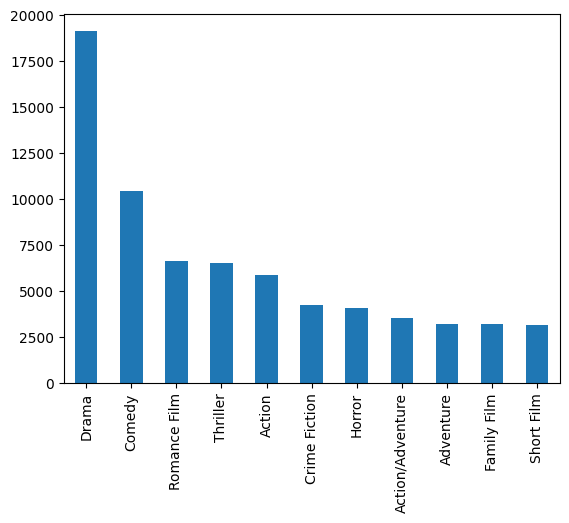

In [11]:
df_labels = movies_genres_df[genres_labels]
label_counts = genres_binary_df.sum().to_dict()
df_labels[sorted(label_counts.keys(), key = label_counts.get, reverse = True)].sum().plot.bar()

In [12]:
# correlation plot for labels
corr = df_labels.corr()
corr.style.background_gradient(cmap='coolwarm')

,Horror,Drama,Family Film,Action,Action/Adventure,Crime Fiction,Adventure,Thriller,Comedy,Short Film,Romance Film
Horror,1.000000,-0.211375,-0.085874,-0.047163,-0.034543,-0.054860,-0.046664,0.162129,-0.101235,-0.070863,-0.123257
Drama,-0.211375,1.000000,-0.096901,-0.078189,-0.059793,0.124757,-0.062957,0.001645,-0.175615,-0.210639,0.193136
Family Film,-0.085874,-0.096901,1.000000,-0.048651,-0.045650,-0.078127,0.201045,-0.104427,0.130980,0.200046,-0.064971
Action,-0.047163,-0.078189,-0.048651,1.000000,0.529286,0.174685,0.222106,0.238240,-0.056029,-0.098633,-0.082219
Action/Adventure,-0.034543,-0.059793,-0.045650,0.529286,1.000000,0.133241,0.178195,0.225642,-0.008334,-0.082853,-0.070006
Crime Fiction,-0.054860,0.124757,-0.078127,0.174685,0.133241,1.000000,-0.020037,0.302398,-0.050052,-0.088309,-0.059482
Adventure,-0.046664,-0.062957,0.201045,0.222106,0.178195,-0.020037,1.000000,-0.001117,-0.007933,-0.066792,-0.045832
Thriller,0.162129,0.001645,-0.104427,0.238240,0.225642,0.302398,-0.001117,1.000000,-0.156797,-0.108752,-0.103014
Comedy,-0.101235,-0.175615,0.130980,-0.056029,-0.008334,-0.050052,-0.007933,-0.156797,1.000000,0.062740,0.126791
Short Film,-0.070863,-0.210639,0.200046,-0.098633,-0.082853,-0.088309,-0.066792,-0.108752,0.062740,1.000000,-0.110862


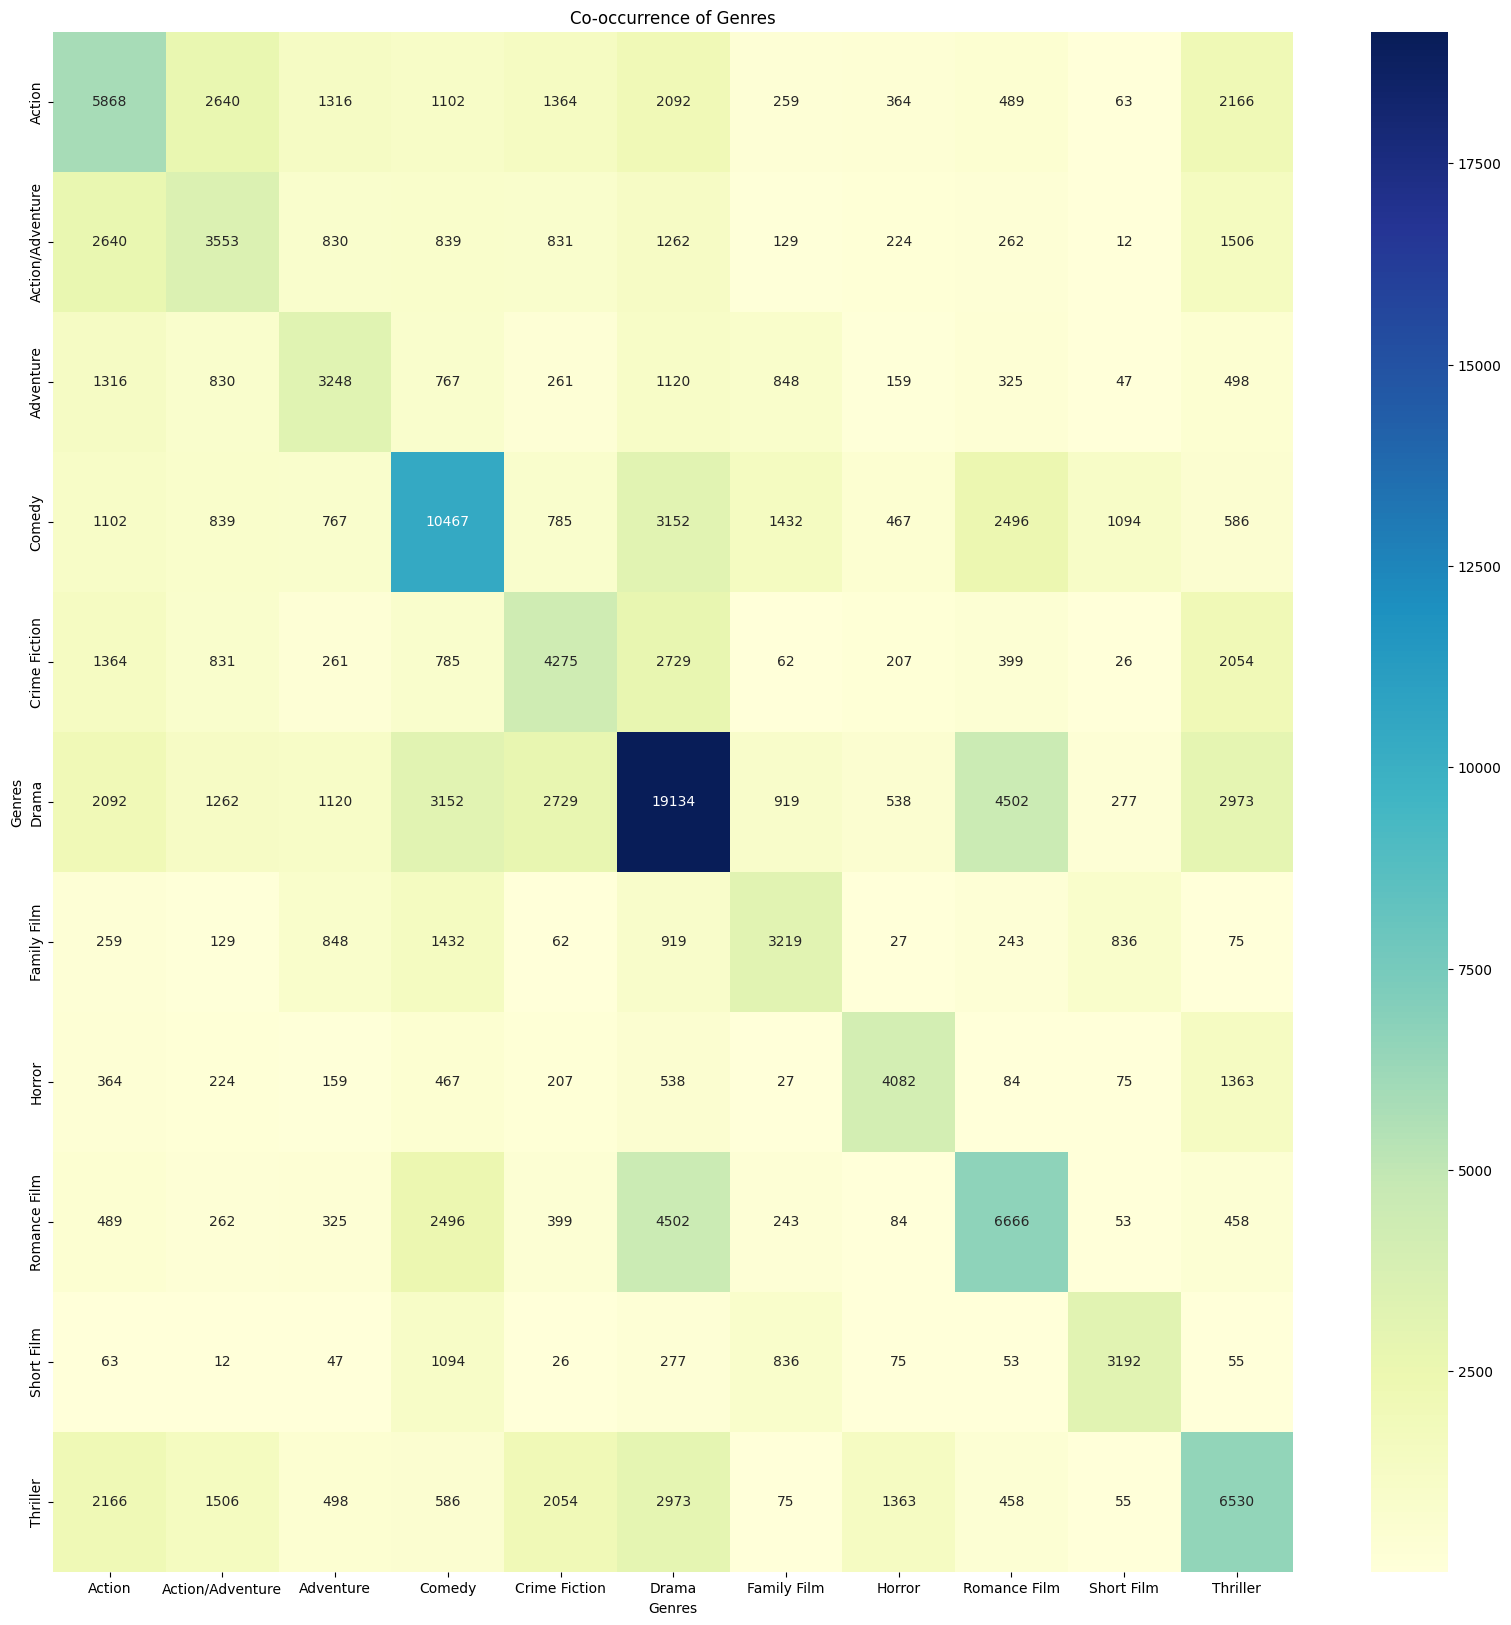

In [13]:
co_occurrence_matrix = genres_binary_df.T.dot(genres_binary_df)
plt.figure(figsize=(20, 20))
sns.heatmap(co_occurrence_matrix, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Co-occurrence of Genres')
plt.xlabel('Genres')
plt.ylabel('Genres')
plt.show()


In [14]:
# conditional probability matrix
def build_conditional_prob_matrix(df, labels):
    cooc = df[labels].values.T.dot(df[labels].values)
    cooc_norm = cooc.copy().astype(np.float32)
    for i in range(cooc_norm.shape[0]):
        cooc_norm[:, i] /= cooc[i, i]
    return cooc_norm

cooc_norm = build_conditional_prob_matrix(movies_genres_df, genres_labels)
cooc_df = pd.DataFrame(cooc_norm, columns = genres_labels, index = genres_labels)
cooc_df.style.background_gradient(cmap = 'coolwarm')

,Horror,Drama,Family Film,Action,Action/Adventure,Crime Fiction,Adventure,Thriller,Comedy,Short Film,Romance Film
Horror,1.000000,0.028117,0.008388,0.062031,0.063045,0.048421,0.048953,0.208729,0.044616,0.023496,0.012601
Drama,0.131798,1.000000,0.285492,0.356510,0.355193,0.638363,0.344828,0.455283,0.301137,0.086779,0.675368
Family Film,0.006614,0.048030,1.000000,0.044138,0.036307,0.014503,0.261084,0.011485,0.136811,0.261905,0.036454
Action,0.089172,0.109334,0.080460,1.000000,0.743034,0.319064,0.405172,0.331700,0.105283,0.019737,0.073357
Action/Adventure,0.054875,0.065956,0.040075,0.449898,1.000000,0.194386,0.255542,0.230628,0.080157,0.003759,0.039304
Crime Fiction,0.050710,0.142626,0.019261,0.232447,0.233887,1.000000,0.080357,0.314548,0.074998,0.008145,0.059856
Adventure,0.038951,0.058535,0.263436,0.224267,0.233605,0.061053,1.000000,0.076263,0.073278,0.014724,0.048755
Thriller,0.333905,0.155378,0.023299,0.369121,0.423867,0.480468,0.153325,1.000000,0.055985,0.017231,0.068707
Comedy,0.114405,0.164733,0.444859,0.187798,0.236138,0.183626,0.236145,0.089740,1.000000,0.342732,0.374437
Short Film,0.018373,0.014477,0.259708,0.010736,0.003377,0.006082,0.014470,0.008423,0.104519,1.000000,0.007951


In [15]:
TARGET_SAMPLES = 3000
target_counts = [TARGET_SAMPLES for _ in genres_labels]
optimal_samples, residuals = nnls(cooc_norm, target_counts)
optimal_samples = optimal_samples.round().astype(np.int32)
optimal_samples

array([2569,    0, 1423,    0, 1811, 1566, 1691,    0,    0, 2404, 1478],
      dtype=int32)

In [16]:
# using NNLS, sampling the dataset
def fancy_sample(df, labels, target_count, cond_prob):
    target_counts = np.array([target_count for _ in labels])
    optimal_samples, residuals = nnls(cond_prob, target_counts)
    optimal_samples = np.ceil(optimal_samples).astype(np.int32)

    df_subs = []
    for i, label in enumerate(labels):
        sub_df = df[df[label] == 1]
        df_subs.append(sub_df.sample(optimal_samples[i], 
                                     replace = len(sub_df) < optimal_samples[i]))
    sampled_df = pd.concat(df_subs)
    return sampled_df

resampled_df = fancy_sample(movies_genres_df, genres_labels, TARGET_SAMPLES, cooc_norm)
resampled_df_labels = resampled_df[genres_labels]

<Axes: >

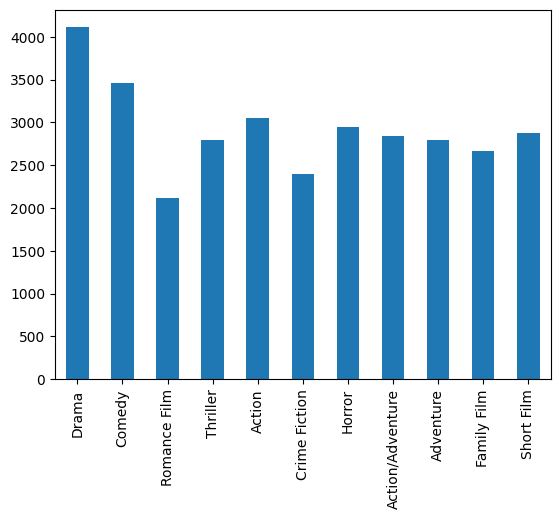

In [17]:
resampled_df[sorted(label_counts.keys(), key = label_counts.get, reverse = True)].sum().plot.bar()

In [18]:
resampled_df

,movie_id,movie_name,summary,Action,Action/Adventure,Adventure,Comedy,Crime Fiction,Drama,Family Film,Horror,Romance Film,Short Film,Thriller
9339,2509613,The Lost World,From a lost expedition to a plateau in Venezu...,0,0,1,0,0,0,0,1,0,0,1
15219,16782,King Kong,"In New York harbor, Carl Denham ([[Robert Arms...",1,1,1,0,0,0,0,1,0,0,0
33932,10183854,Head of the Family,"Howard is the meanest nastiest thug in town, ...",0,0,0,0,0,0,0,1,0,0,0
32908,5117656,Scarecrow,Lester Dwervick has always been sort of diffe...,0,0,0,0,0,0,0,1,0,0,0
2299,901907,The Magician,"In the Latin Quarter of Paris, sculptress Marg...",0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6177,4339865,Princess Tam Tam,"Max de Mirecourt , a frustrated writer, goes t...",0,0,0,1,0,1,0,0,1,0,0
40298,29004017,Fjorton suger,Emma is fourteen years old and lives with her ...,0,0,0,0,0,1,0,0,1,0,0
28019,9252228,Aag,Kewal reluctantly accepts his father 's deman...,0,0,0,0,0,1,0,0,1,0,0
7438,1997163,The Man Without a Past,The film begins with an unnamed man arriving b...,0,0,0,1,1,1,0,0,1,0,1


In [19]:
# analyse the different genre combinations
# genre_counts_df = movies_genre.groupby('genres').size().reset_index(name='count').sort_values(by='count', ascending=False)
# genre_counts_df
# genre_counts_df[genre_counts_df['count']>500]

In [20]:
def cleaner (summary):
    summary = summary.replace('"','')
    summary = summary.replace("'"," ")
    return summary

resampled_df['summary'] = resampled_df['summary'].apply(cleaner)


In [21]:
resampled_df['summary']

9339      From a lost expedition to a plateau in Venezu...
15219    In New York harbor, Carl Denham ([[Robert Arms...
33932    Howard  is the meanest nastiest thug in town, ...
32908    Lester Dwervick  has always been sort of diffe...
2299     In the Latin Quarter of Paris, sculptress Marg...
                               ...                        
6177     Max de Mirecourt , a frustrated writer, goes t...
40298    Emma is fourteen years old and lives with her ...
28019    Kewal  reluctantly accepts his father  s deman...
7438     The film begins with an unnamed man arriving b...
1467     Wayland is a clockmaker whose ambition is to b...
Name: summary, Length: 12945, dtype: object

In [22]:
resampled_df.to_csv('./Dataset_MovieSummaries/Dataset.csv')